In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

batch_size = 256
classes = 10

def Relu(y):
    return torch.maximum(torch.tensor(0), y)

def softmax(y):
    for i in range(len(y)):
        y[i] = torch.exp(y[i])/torch.sum(torch.exp(y[i]))
    return y  
        
def cross_entropy_loss(p, q):
    tmp = torch.zeros((len(q), classes))
    for i in range((len(q))):
        tmp[i][p[i].item()] += 1.0
    
    ans = torch.zeros((len(q)))
    
    for i in range((len(q))):
        ans[i] = torch.sum(-(tmp[i]*torch.log(q[i])))    
    return torch.mean(ans)

def whichclass(pred_y):
    _, label = torch.max(pred_y, 1)
    return label        

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

fashion_mnist_trainval = FashionMNIST("FashionMNIST", train=True, download=True, transform=transform)
fashion_mnist_test = FashionMNIST("FashionMNIST", train=False, download=True, transform=transform)

n_samples = len(fashion_mnist_trainval) 
train_size = int(len(fashion_mnist_trainval) * 0.8) 
val_size = n_samples - train_size 

train_dataset, val_dataset = torch.utils.data.random_split(fashion_mnist_trainval, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=True)

w1 = torch.normal(0, 0.01, size=(28*28, 256), requires_grad=True)
b1 = torch.zeros(256, requires_grad=True)
w2 = torch.normal(0, 0.01, size=(256, classes), requires_grad=True)
b2 = torch.zeros(classes, requires_grad=True)

epoch_num = 1000
optimizer = optim.SGD([w1, b1, w2, b2], lr = 0.02)
running_loss = np.zeros(epoch_num)
valrunning_loss = np.zeros(epoch_num)
early_count = 0
min_loss = 10
delta = 0.001

for epoch in range(epoch_num):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1,28*28)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = torch.matmul(images, w1)+ b1
            outputs = Relu(outputs)
            outputs = torch.matmul(outputs, w2)+ b2
            pred_y = softmax(outputs)                 
            loss = cross_entropy_loss(labels, pred_y) 
            running_loss[epoch] += torch.sum(loss)/batch_size

        loss.backward()
        optimizer.step()
    
    for i, (images, labels) in enumerate(val_loader): 
        images = images.view(-1,28*28)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = torch.matmul(images, w1)+ b1
            outputs = Relu(outputs)
            outputs = torch.matmul(outputs, w2)+ b2
            pred_y = softmax(outputs)                 
            val_loss = cross_entropy_loss(labels, pred_y) 
            valrunning_loss[epoch] += torch.sum(val_loss)/batch_size


    if valrunning_loss[epoch] >= min_loss:
        count += 1
        print("count:", count)
    else:
        count = 0
        min_loss = valrunning_loss[epoch]
        
    if count >= 5:
        print("early stopping")
        break
        
    print("epoch : %d, train_loss : %.4lf, val_loss : %4lf" % (epoch, running_loss[epoch],valrunning_loss[epoch]))
        
        
print(running_loss)

epoch : 0, train_loss : 1.0416, val_loss : 0.157547
epoch : 1, train_loss : 0.5438, val_loss : 0.122510
epoch : 2, train_loss : 0.4628, val_loss : 0.108854
epoch : 3, train_loss : 0.4216, val_loss : 0.100766
epoch : 4, train_loss : 0.3946, val_loss : 0.095892
epoch : 5, train_loss : 0.3760, val_loss : 0.091877
epoch : 6, train_loss : 0.3622, val_loss : 0.088390
epoch : 7, train_loss : 0.3513, val_loss : 0.086524
epoch : 8, train_loss : 0.3422, val_loss : 0.084825
epoch : 9, train_loss : 0.3344, val_loss : 0.083425
epoch : 10, train_loss : 0.3276, val_loss : 0.081439
epoch : 11, train_loss : 0.3221, val_loss : 0.080694
count: 1
epoch : 12, train_loss : 0.3170, val_loss : 0.080935
epoch : 13, train_loss : 0.3123, val_loss : 0.078140
epoch : 14, train_loss : 0.3087, val_loss : 0.078116
epoch : 15, train_loss : 0.3039, val_loss : 0.076304
epoch : 16, train_loss : 0.3005, val_loss : 0.075577
count: 1
epoch : 17, train_loss : 0.2970, val_loss : 0.075769
epoch : 18, train_loss : 0.2937, val_l

In [3]:
train_acc = 0.0
correct = 0.0
count = 0.0

for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,28*28)
    outputs = torch.matmul(images, w1)+ b1
    outputs = Relu(outputs)
    outputs = torch.matmul(outputs, w2)+ b2
    pred_label1 = softmax(outputs)
    pred_label = whichclass(pred_label1)
    
    for j in range(len(pred_label)):
        if pred_label[j].int() == labels[j]:
            correct += 1
        
        count += 1

train_acc = correct/count
print("train_acc:",train_acc)

test_acc = 0.0
correct = 0.0
count = 0.0

for i, (images, labels) in enumerate(test_loader):
    images = images.view(-1,28*28)
    outputs = torch.matmul(images, w1)+ b1
    outputs = Relu(outputs)
    outputs = torch.matmul(outputs, w2)+ b2
    pred_label1 = softmax(outputs)
    pred_label = whichclass(pred_label1)
    
    for j in range(len(pred_label)):
        if pred_label[j].int() == labels[j]:
            correct += 1
        
        count += 1

test_acc = correct/count
print("test_acc:",test_acc)

train_acc: 0.9112916666666667
test_acc: 0.8737


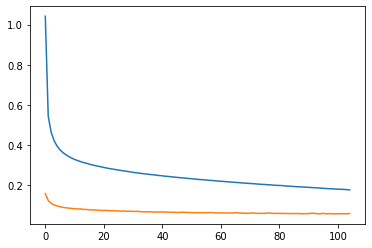

In [4]:
plt.plot(running_loss[0:epoch+1])
plt.plot(valrunning_loss[0:epoch+1])